# TP Final Integrador Visión por Computadora II - CEIA - FIUBA - Cohorte 16

Alumnos: Fabricio Lopretto (a1616) y Santiago José Olaciregui (a1611)

## Implementación de Red YOLO para la detección de objetos: Conjunto de Entrenamiento sin preprocesamiento.

### Objetivos:

Realizar el entrenamiento (train) y la prueba (test) de una red neuronal de detección de objetos sobre un dataset de imagenes de cartas del juego de mesa UNO.

Se busca la generación de artefactos que permitan analizar la diferencia de desempeño de la red al utilizar el conjunto de datos de entrenamiento con y sin preprocesamiento.

### Características:

En esta notebook, se utiliza el conjunto de entrenamiento sin realizarle ningún tipo preporcesamiento.


In [ ]:
# Instala los modulos necesarios
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install requests beautifulsoup4
!pip3 install torch torchvision torchaudio
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 52.3 MB/s eta 0:00:00


In [ ]:
# Importa las librerias necesarias
from google.colab import drive
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from IPython.display import display
from pathlib import Path
from ultralytics import YOLO
import os

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
import torchvision.transforms as transforms

import tensorflow as tf

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Ejemplo del conjunto de datos utilizado

In [ ]:
# URL de la carpeta en el repositorio de GitHub (no la URL raw)
url = "https://github.com/fabriciolopretto/VpC2/tree/main/data/data_original/train/images/"

# Realiza la solicitud y analiza el HTML
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Lista para almacenar URLs de las imágenes
image_urls = []

# Encuentra todas las etiquetas 'a' que enlacen a imágenes
for link in soup.find_all('a', href=True):
    href = link['href']
    if href.endswith(('.jpg', '.png', '.jpeg', '.gif')):  # Filtra por tipos de imagen
        # Construye la URL de la imagen en bruto
        raw_url = f"https://raw.githubusercontent.com{href.replace('/blob', '')}"
        image_urls.append(raw_url)

# Imprime o usa la lista de URLs de imágenes
print("URLs de las imágenes:")
for img_url in image_urls:
    print(img_url)


URLs de las imágenes:
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_original/train/images/000244709_jpg.rf.6ad3fbffe1283e6d8f48a207aecfb9cd.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_original/train/images/000244709_jpg.rf.6ad3fbffe1283e6d8f48a207aecfb9cd.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_original/train/images/000390579_jpg.rf.ecc8f1090e6d61590576896ba79f5a3c.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_original/train/images/000390579_jpg.rf.ecc8f1090e6d61590576896ba79f5a3c.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_original/train/images/000413060_jpg.rf.c6da079ccf2c5b108ef52301919c5576.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_original/train/images/000413060_jpg.rf.c6da079ccf2c5b108ef52301919c5576.jpg
https://raw.githubusercontent.com/fabriciolopretto/VpC2/main/data/data_original/train/images/000

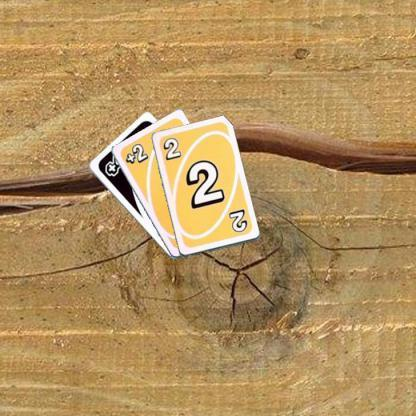

In [ ]:
# Muestra la primera imagen del dataset a modo de prueba
url = image_urls[0]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

In [ ]:
# Clona el repositorio de GitHub con los conjuntos de datos
!git clone https://github.com/fabriciolopretto/VpC2.git

Cloning into 'VpC2'...
remote: Enumerating objects: 24305, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 24305 (delta 0), reused 0 (delta 0), pack-reused 24304 (from 1)
Receiving objects: 100% (24305/24305), 674.49 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (30583/30583), done.


## Red Neuronal YOLO

### Ejecución del modelo:

**1. Carga del modelo YOLOv8.** Se utiliza un modelo preentrenado (weights inicializados) basado en la arquitectura YOLOv8n. En el código, cuando se instancia el modelo con YOLO(MODEL_NAME) (donde MODEL_NAME = "yolov8n"), el framework carga automáticamente los pesos preentrenados en el dataset COCO. Estos pesos contienen conocimiento general que el modelo ha aprendido, como la capacidad de detectar bordes, esquinas, y formas básicas. COCO incluye clases como "números" o "carteles", que comparten similitudes con los números en las cartas UNO. Luego, durante el entrenamiento con el nuevo dataset, los pesos del modelo se ajustan gradualmente para adaptarse al dataset específico de las cartas del juego UNO. Las primeras capas (cercanas a la entrada) se ajustan poco o nada, porque representan características genéricas (como bordes o texturas).Las últimas capas (cercanas a la salida) se reentrenan para reconocer las características y clases específicas de las cartas. El modelo se ajusta para reconocer los números y posiblemente las características únicas de las cartas UNO (formas, colores, texturas).

**2. Data Augumentation.** Se aplica automáticamente para enriquecer las muestras de entrenamiento. Entre las operaciones realizadas se tiene escalado manteniendo las proporciones, rotación en un rango de ángulos, recorte aleatorio de partes de las imagenes, traslación dentro del dominio de la imagen, ajuste de brillo, saturación y de contraste, introducción de ruido y mezcla de imagenes. Además, cada lote de entrenamiento recibe transformaciones únicas. No todas las operaciones se aplican a cada imagen; hay una probabilidad definida para cada una (por ejemplo, un 50% para rotaciones o un 30% para cambios de brillo).

**3. Workers.** Procesos en paralelo (4) para acelerar el preprocesamiento de datos.

**4. Evaluación.** Se evalúa el modelo en el conjunto de prueba definido en el archivo YAML. Para esto, utiliza métricas como mAP@50 (precisión promedio para un umbral de IoU: Intersection over Union) y/o mAP@50-95 como (precisión promedio en un rango de umbrales 50% a 95%).

**5. Resultados**: Los resultados (pesos entrenados, gráficos de pérdida, métricas) se guardan en el directorio runs/detect/UNO_detection.

Archivo YAML guardado en: /content/VpC2/data.yaml
Iniciando entrenamiento YOLOv8...


100%|██████████| 6.25M/6.25M [00:00<00:00, 259MB/s]


Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/VpC2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=UNO_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

100%|██████████| 755k/755k [00:00<00:00, 79.2MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 220MB/s]


AMP: checks passed ✅


train: Scanning /content/VpC2/data/data_original/train/labels... 6295 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6295/6295 [00:04<00:00, 1471.73it/s]


train: New cache created: /content/VpC2/data/data_original/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/VpC2/data/data_original/test/labels... 899 images, 0 backgrounds, 0 corrupt: 100%|██████████| 899/899 [00:00<00:00, 1002.75it/s]

val: New cache created: /content/VpC2/data/data_original/test/labels.cache


Plotting labels to runs/detect/UNO_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/UNO_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.05G      1.318      3.036     0.9551         31        416: 100%|██████████| 394/394 [01:21<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.58it/s]


                   all        899       2697      0.637      0.709      0.719      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.986G     0.9593      1.304     0.8733         23        416: 100%|██████████| 394/394 [01:19<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.99it/s]

                   all        899       2697      0.948      0.934      0.981      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.994G     0.8657     0.9392     0.8554         32        416: 100%|██████████| 394/394 [01:16<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.08it/s]


                   all        899       2697      0.967      0.968      0.991      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.992G     0.8134     0.7883      0.845         26        416: 100%|██████████| 394/394 [01:16<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.02it/s]

                   all        899       2697      0.983      0.986      0.992      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.99G     0.7673      0.701     0.8367         42        416: 100%|██████████| 394/394 [01:16<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.99it/s]

                   all        899       2697      0.978      0.985      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.03G     0.7375     0.6285     0.8294         24        416: 100%|██████████| 394/394 [01:16<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.04it/s]

                   all        899       2697      0.978      0.989       0.99       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.992G     0.7148      0.587     0.8267         29        416: 100%|██████████| 394/394 [01:16<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]

                   all        899       2697      0.981       0.98      0.988      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.02G     0.6895     0.5513     0.8251         39        416: 100%|██████████| 394/394 [01:16<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.01it/s]

                   all        899       2697       0.99      0.992       0.99      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.988G     0.6827     0.5289      0.822         24        416: 100%|██████████| 394/394 [01:18<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.51it/s]

                   all        899       2697      0.991      0.992      0.989      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      0.99G      0.661     0.5027     0.8201         52        416: 100%|██████████| 394/394 [01:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.96it/s]


                   all        899       2697      0.992      0.994       0.99      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.984G     0.6554     0.4864     0.8166         32        416: 100%|██████████| 394/394 [01:16<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.95it/s]

                   all        899       2697      0.984      0.992       0.99       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.992G      0.647     0.4771     0.8162         15        416: 100%|██████████| 394/394 [01:18<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]

                   all        899       2697      0.993      0.993      0.993      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.994G     0.6358     0.4588     0.8164         32        416: 100%|██████████| 394/394 [01:16<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.92it/s]

                   all        899       2697      0.993      0.994      0.993      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.984G     0.6258     0.4495     0.8124         38        416: 100%|██████████| 394/394 [01:16<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.98it/s]

                   all        899       2697      0.985      0.987      0.989       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.986G     0.6224     0.4416     0.8129         27        416: 100%|██████████| 394/394 [01:15<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.62it/s]

                   all        899       2697      0.995      0.997      0.994       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.988G     0.6205     0.4351     0.8116         27        416: 100%|██████████| 394/394 [01:16<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.97it/s]

                   all        899       2697      0.989      0.991      0.989      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.02G      0.613      0.425     0.8115         44        416: 100%|██████████| 394/394 [01:19<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.45it/s]

                   all        899       2697      0.994      0.996      0.993       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.02G     0.6026     0.4145     0.8117         12        416: 100%|██████████| 394/394 [01:16<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]

                   all        899       2697      0.992      0.992      0.991      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.988G     0.5988     0.4127     0.8091         27        416: 100%|██████████| 394/394 [01:17<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.92it/s]

                   all        899       2697      0.993      0.995      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.02G     0.5916     0.4017     0.8095         37        416: 100%|██████████| 394/394 [01:16<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.58it/s]

                   all        899       2697      0.992      0.994      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.03G     0.5859     0.4015     0.8064         26        416: 100%|██████████| 394/394 [01:17<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.96it/s]

                   all        899       2697      0.991      0.994      0.992      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.02G     0.5805     0.3896     0.8083         35        416: 100%|██████████| 394/394 [01:18<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.72it/s]

                   all        899       2697      0.993      0.995      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.994G     0.5778     0.3909     0.8073         24        416: 100%|██████████| 394/394 [01:16<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.99it/s]


                   all        899       2697      0.994      0.996      0.993      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.02G     0.5712     0.3795     0.8055         33        416: 100%|██████████| 394/394 [01:17<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.91it/s]

                   all        899       2697      0.992      0.991       0.99      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      0.99G     0.5678     0.3794     0.8046         31        416: 100%|██████████| 394/394 [01:15<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.86it/s]

                   all        899       2697      0.993      0.994      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.994G       0.57     0.3733     0.8057         28        416: 100%|██████████| 394/394 [01:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.90it/s]

                   all        899       2697      0.992      0.993      0.991      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.992G     0.5633     0.3695     0.8043         25        416: 100%|██████████| 394/394 [01:18<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.67it/s]

                   all        899       2697      0.993      0.995      0.992      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.992G     0.5558     0.3704     0.8034         27        416: 100%|██████████| 394/394 [01:16<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]

                   all        899       2697      0.991      0.993      0.991      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.986G     0.5557     0.3642     0.8039         28        416: 100%|██████████| 394/394 [01:17<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.24it/s]

                   all        899       2697      0.991      0.994      0.989      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.02G     0.5513     0.3594     0.8027         39        416: 100%|██████████| 394/394 [01:15<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]

                   all        899       2697      0.992      0.994      0.992      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.986G      0.549     0.3575     0.8025         24        416: 100%|██████████| 394/394 [01:16<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.97it/s]

                   all        899       2697      0.994      0.995      0.992      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      0.99G     0.5431     0.3542     0.8017         39        416: 100%|██████████| 394/394 [01:16<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]

                   all        899       2697      0.992      0.995      0.992      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.03G     0.5358     0.3476     0.8019         24        416: 100%|██████████| 394/394 [01:14<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.26it/s]

                   all        899       2697       0.99      0.995      0.992      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.03G     0.5358     0.3448     0.8002         21        416: 100%|██████████| 394/394 [01:16<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.64it/s]

                   all        899       2697      0.992      0.994      0.991      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.988G     0.5359      0.345     0.8011         25        416: 100%|██████████| 394/394 [01:17<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.48it/s]

                   all        899       2697      0.993      0.995      0.992      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.994G     0.5306     0.3403     0.7993         29        416: 100%|██████████| 394/394 [01:18<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.89it/s]

                   all        899       2697      0.993      0.995      0.992      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.984G     0.5264     0.3396     0.8011         12        416: 100%|██████████| 394/394 [01:17<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.97it/s]

                   all        899       2697      0.993      0.994      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.03G     0.5236     0.3345     0.7997         22        416: 100%|██████████| 394/394 [01:17<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]

                   all        899       2697      0.992      0.994      0.992      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.994G     0.5199      0.333     0.7998         25        416: 100%|██████████| 394/394 [01:16<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.77it/s]

                   all        899       2697      0.992      0.994      0.991      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.03G     0.5172     0.3304     0.7979         27        416: 100%|██████████| 394/394 [01:16<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.04it/s]

                   all        899       2697      0.992      0.995      0.991      0.899


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.984G     0.4784     0.2731     0.7905         21        416: 100%|██████████| 394/394 [01:17<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.09it/s]

                   all        899       2697      0.993      0.995      0.993      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.984G     0.4707     0.2692       0.79         21        416: 100%|██████████| 394/394 [01:13<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.32it/s]

                   all        899       2697      0.992      0.995      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.984G      0.469     0.2678     0.7894         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.62it/s]

                   all        899       2697      0.993      0.996      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.984G     0.4659     0.2634     0.7889         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.94it/s]

                   all        899       2697      0.993      0.996      0.993      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.984G     0.4601     0.2599      0.788         21        416: 100%|██████████| 394/394 [01:13<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.62it/s]

                   all        899       2697      0.993      0.995      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.984G     0.4552     0.2561     0.7875         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  5.94it/s]

                   all        899       2697      0.992      0.995      0.993      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.984G     0.4557     0.2575     0.7869         21        416: 100%|██████████| 394/394 [01:12<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.19it/s]

                   all        899       2697      0.993      0.995      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.984G     0.4503     0.2526     0.7872         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.55it/s]

                   all        899       2697      0.992      0.996      0.993      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.984G     0.4484     0.2509     0.7872         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  5.53it/s]

                   all        899       2697      0.992      0.995      0.992       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.984G     0.4465     0.2489     0.7867         21        416: 100%|██████████| 394/394 [01:14<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]

                   all        899       2697      0.992      0.994      0.992      0.912



50 epochs completed in 1.156 hours.
Optimizer stripped from runs/detect/UNO_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/UNO_detection/weights/best.pt, 6.2MB

Validating runs/detect/UNO_detection/weights/best.pt...
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.60it/s]


                   all        899       2697       0.99      0.994      0.993      0.886
                     0        166        175      0.995          1      0.995      0.904
                     1        153        160      0.999          1      0.995      0.885
                     2        165        171      0.986          1      0.995      0.908
                     3        190        205      0.997          1      0.995      0.894
                     4        168        183      0.998          1      0.995      0.902
                     5        164        179      0.992          1      0.995      0.904
                     6        175        190      0.994          1      0.995       0.88
                     7        177        189      0.997          1      0.995      0.897
                     8        170        192      0.988          1      0.995      0.878
                     9        179        187      0.998          1      0.995      0.883
                    1

val: Scanning /content/VpC2/data/data_original/test/labels.cache... 899 images, 0 backgrounds, 0 corrupt: 100%|██████████| 899/899 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:07<00:00,  7.71it/s]


                   all        899       2697      0.992      0.995      0.993      0.911
                     0        166        175      0.997          1      0.995      0.929
                     1        153        160      0.998          1      0.995      0.909
                     2        165        171      0.992          1      0.995      0.928
                     3        190        205      0.998          1      0.995      0.916
                     4        168        183      0.998          1      0.995      0.929
                     5        164        179      0.997          1      0.995      0.927
                     6        175        190      0.997          1      0.995      0.906
                     7        177        189      0.998          1      0.995      0.919
                     8        170        192      0.996          1      0.995      0.908
                     9        179        187      0.997          1      0.995      0.908
                    1

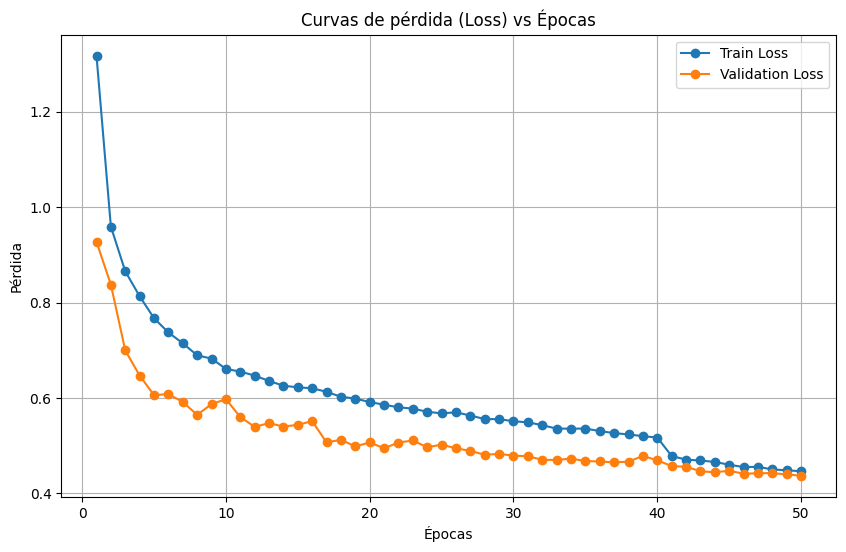

Las columnas necesarias no están en el archivo de resultados.


In [ ]:
# -----------------------------
# Configuración inicial
# -----------------------------
# Directorios del dataset (rutas locales después de clonar el repositorio)
DATASET_DIR = "/content/VpC2/"  # Ruta del repositorio clonado en Google Colab
TRAIN_IMAGES_DIR = os.path.join(DATASET_DIR, "data/data_original/train/images/")
TRAIN_LABELS_DIR = os.path.join(DATASET_DIR, "data/data_original/train/labels/")
TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "data/data_original/test/images/")
TEST_LABELS_DIR = os.path.join(DATASET_DIR, "data/data_original/test/labels/")

# Archivo de configuración de datos para YOLOv8 (con rutas locales)
DATA_YAML = """
train: /content/VpC2/data/data_original/train/images/
val: /content/VpC2/data/data_original/test/images/

nc: 15  # Número de clases
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
"""

# Guarda el archivo YAML
DATA_YAML_PATH = Path(DATASET_DIR) / "data.yaml"
with open(DATA_YAML_PATH, "w") as file:
    file.write(DATA_YAML)

print(f"Archivo YAML guardado en: {DATA_YAML_PATH}")

# Hiperparámetros del entrenamiento
MODEL_NAME = "yolov8n"  # Arquitectura (nano, pequeña para este caso)
EPOCHS = 50
BATCH_SIZE = 16
IMAGE_SIZE = 416

# -----------------------------
# Entrenamiento
# -----------------------------
def train_yolov8():
    """
    Entrena un modelo YOLOv8 en el dataset proporcionado.

    Se carga un modelo preentrenado de YOLOv8 utilizando la arquitectura especificada.
    El modelo se entrena utilizando los datos definidos en el archivo YAML.
    Se definen los parámetros del entrenamiento.
    El número de workers (procesos que trabajan en paralelo) se establece en 4.
    Se realiza DA utiliando el pipeline de YOLO.
    El nombre del directorio donde se guardarán los resultados se define como "UNO_detection".
    """
    print("Iniciando entrenamiento YOLOv8...")
    model = YOLO(MODEL_NAME)
    model.train(
        data=str(DATA_YAML_PATH),
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMAGE_SIZE,
        workers=4,
        augment=True,
        name="UNO_detection"
    )
    print("Entrenamiento finalizado.")


# -----------------------------
# Evaluación
# -----------------------------
def evaluate_yolov8():
    """
    Evalua el modelo YOLOv8 en el conjunto de prueba.

    Se carga el mejor modelo entrenado desde el directorio de resultados.
    Se realiza la evaluación utilizando el conjunto de test especificado en el archivo YAML.
    El resultado de la evaluación incluye dos métricas comunes de precisión para
    modelos de detección de objetos: mAP@50 (mean Average Precision a 50% de IoU)
    y mAP@50-95 (mean Average Precision en varios umbrales de IoU).
    """
    print("Evaluando el modelo YOLOv8...")
    model = YOLO(f"runs/detect/UNO_detection/weights/best.pt")
    results = model.val(data=str(DATA_YAML_PATH), imgsz=IMAGE_SIZE)
    print(f"mAP@50: {results.box.map50:.4f}, mAP@50-95: {results.box.map:.4f}")


# -----------------------------
# Predicción
# -----------------------------
def predict_yolov8(image_path):
    """
    Realiza predicciones en una imagen usando el modelo entrenado.

    Se carga el mejor modelo entrenado (best.pt).
    Se realiza la predicción sobre la imagen especificada.
    Se establece un umbral de confianza (conf=0.25), lo que significa que solo se
    considerarán las predicciones con una probabilidad superior al 25%.
    Se guarda la imagen con las predicciones realizadas y se devuelve el resultado.
    """
    print(f"Realizando predicciones en: {image_path}")
    model = YOLO(f"runs/detect/UNO_detection/weights/best.pt")
    results = model.predict(source=image_path, save=True, imgsz=IMAGE_SIZE, conf=0.25)
    return results


# -----------------------------
# Función principal
# -----------------------------
if __name__ == "__main__":
    # 1. Entrena el modelo
    train_yolov8()

    # 2. Evalua el modelo
    evaluate_yolov8()

    # 3. Realiza una predicción de ejemplo
    IMAGE_PATH = "/content/VpC2/data/data_original/valid/images/000051456_jpg.rf.051c6052d963332a46ef6d2a64bfe156.jpg"
    results = predict_yolov8(IMAGE_PATH)
    print("Predicción completada. Resultados guardados.")


### Observaciones:

El modelo genera en el directorio local del entorno de colab varios artefactos. Entre ellos se tiene:

1. Matriz de confusión para cada clase (cartas del 1 al 15).
2. Distribución de cantidad de objetos por clase.
3. Distribución espacial en el dominio de la imagen.
4. Distribución de alto/anchos de los objetos detectados.
5. Curvas de Precisión vs Recall media y por clase.
6. Curvas Precisión vs Confianza media y por clase.
7. Curvas Recall vs Confianza media y por clase.
8. Curvas de F1-Score vs Confianza media y por clase.
9. Archivo csv con las metricas mencionadas y otras como mAP50, mAP50-95, etc.

Se utilizaron los siguientes hiperparámetros:

1. 50 épocas.
2. Tamaño de cada lote (batck size) igual a 16.

El modelo presentó un buen desempeño. En el gráfico de pérdida vs épocas para el  conjunto de entrenamiento y validación, se observó a ambas curvas convergiendo al mismo mínimo, sin mostrar signos de sobreajuste (o subajuste).

Gráficos adicionales se muestran en la notebook *5_ploteos_adicionales_YOLO* en donde se grafican y analizan métricas almacenadas en los artefactos generados por la Red.